In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import cycle
import random
from random import choice


# SKLearn Tools
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
label_encoder_dict = defaultdict(LabelEncoder)

In [2]:
# Extra Personalised Settings
sns.set_style("whitegrid")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
tqdm.pandas()
random.seed(8)

In [3]:
# Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
ss_df = pd.read_csv('sample_submission.csv')
df_dict = {
    "Training data": train_df,
    "Test data": test_df,
    "Sample submission": ss_df,
}

In [4]:
# Examine the shapes
for df_key in df_dict.keys():
    print(f"- {df_key} -\nShape: {df_dict[df_key].shape} - {df_dict[df_key].shape[0]} Rows x {df_dict[df_key].shape[1]} Columns\nFeatures: {df_dict[df_key].columns.values}\n")
    print(df_dict[df_key].head(10))
    print('─'*70)

- Training data -
Shape: (1642, 10) - 1642 Rows x 10 Columns
Features: ['model' 'year' 'motor_type' 'running' 'wheel' 'color' 'type' 'status'
 'motor_volume' 'price']

           model  year motor_type        running wheel    color   type  \
0         toyota  2022     petrol       3000  km  left  skyblue  sedan   
1  mercedes-benz  2014     petrol     132000  km  left    black  sedan   
2            kia  2018     petrol   95000  miles  left    other  sedan   
3  mercedes-benz  2002     petrol  137000  miles  left   golden  sedan   
4  mercedes-benz  2017     petrol     130000  km  left    black  sedan   
5  mercedes-benz  2001     petrol     286293  km  left     blue  sedan   
6         nissan  2019     petrol   49000  miles  left     gray    suv   
7         nissan  2018     petrol   70000  miles  left   silver    suv   
8  mercedes-benz  2019     petrol      85000  km  left    black  sedan   
9        hyundai  2021     petrol   58000  miles  left   silver  sedan   

      status  mot

In [5]:
# Quick data type cleanup
# We need to transform the running column into numerical data, all in km
def running_func(running_str):
    if running_str[-2:] == 'km':
        return int(running_str[:-3])
    else:
        return np.round(1.6*int(running_str[:-6]))
        
def add_odometer(df):
    df['running_km'] = df.apply(lambda x: running_func(x['running']), axis=1)
    return

add_odometer(train_df)

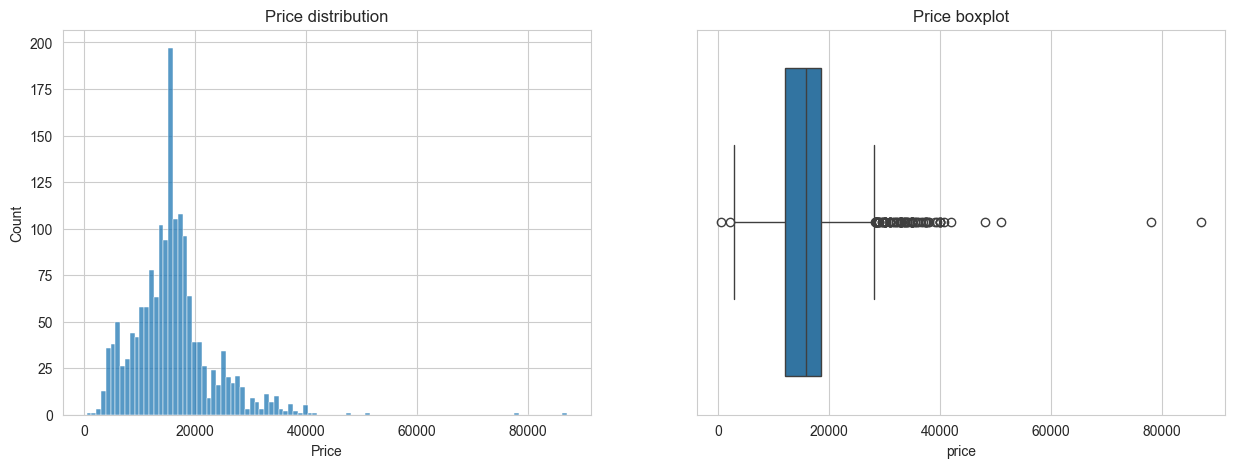

In [6]:
# Examine prices in training data
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('Price distribution')
ax[0].set_xlabel('Price')
sns.histplot(train_df["price"], bins=100, ax=ax[0])
ax[1].set_title('Price boxplot')
sns.boxplot(train_df["price"], ax=ax[1], orient='h')
plt.show()

Feautre: model


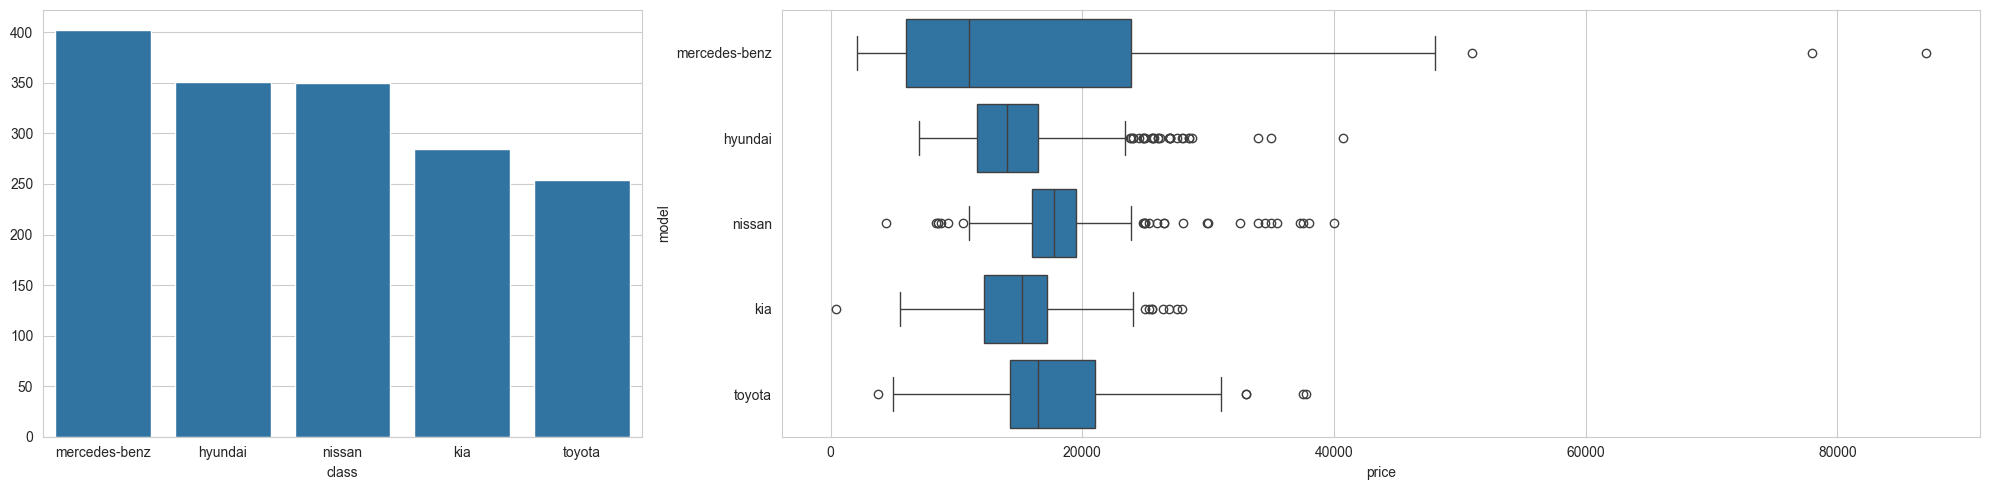

Feautre: year


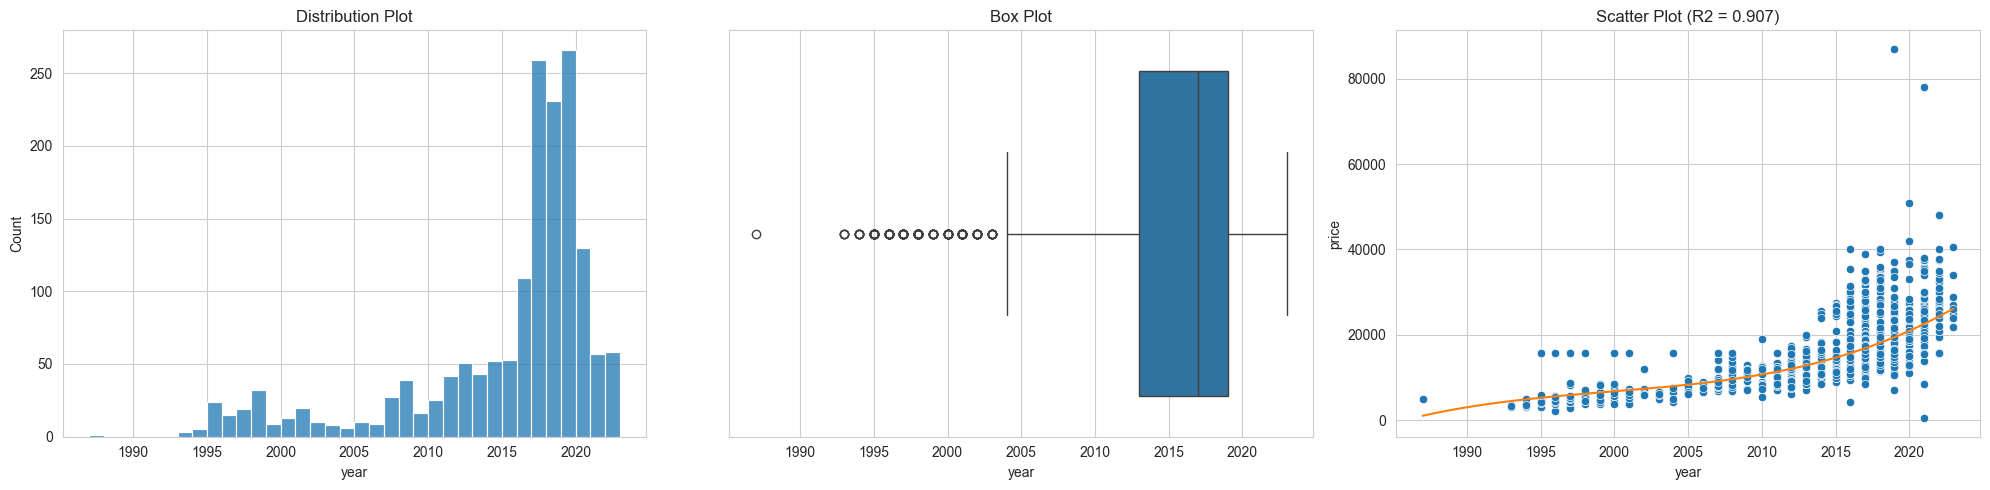

Feautre: motor_type


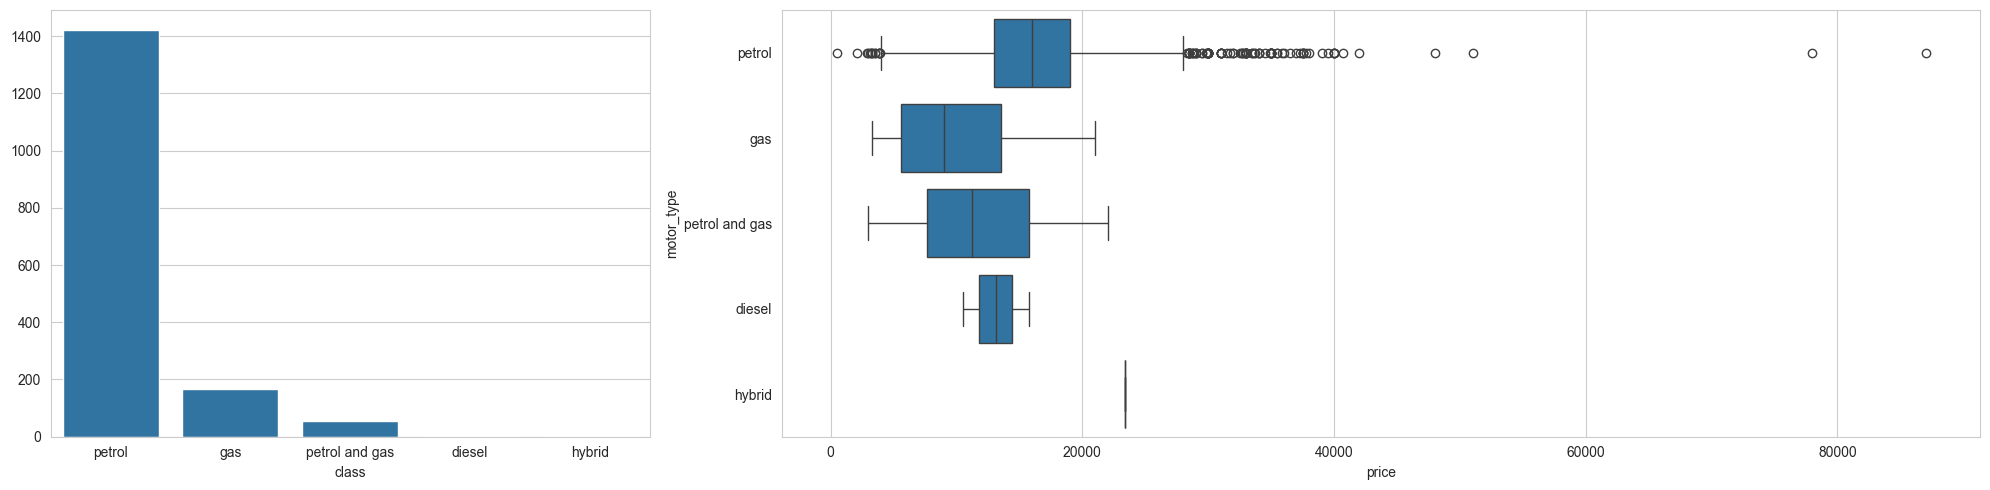

Feautre: running
More than 10 categorical features: 643. Skipping.
Feautre: wheel


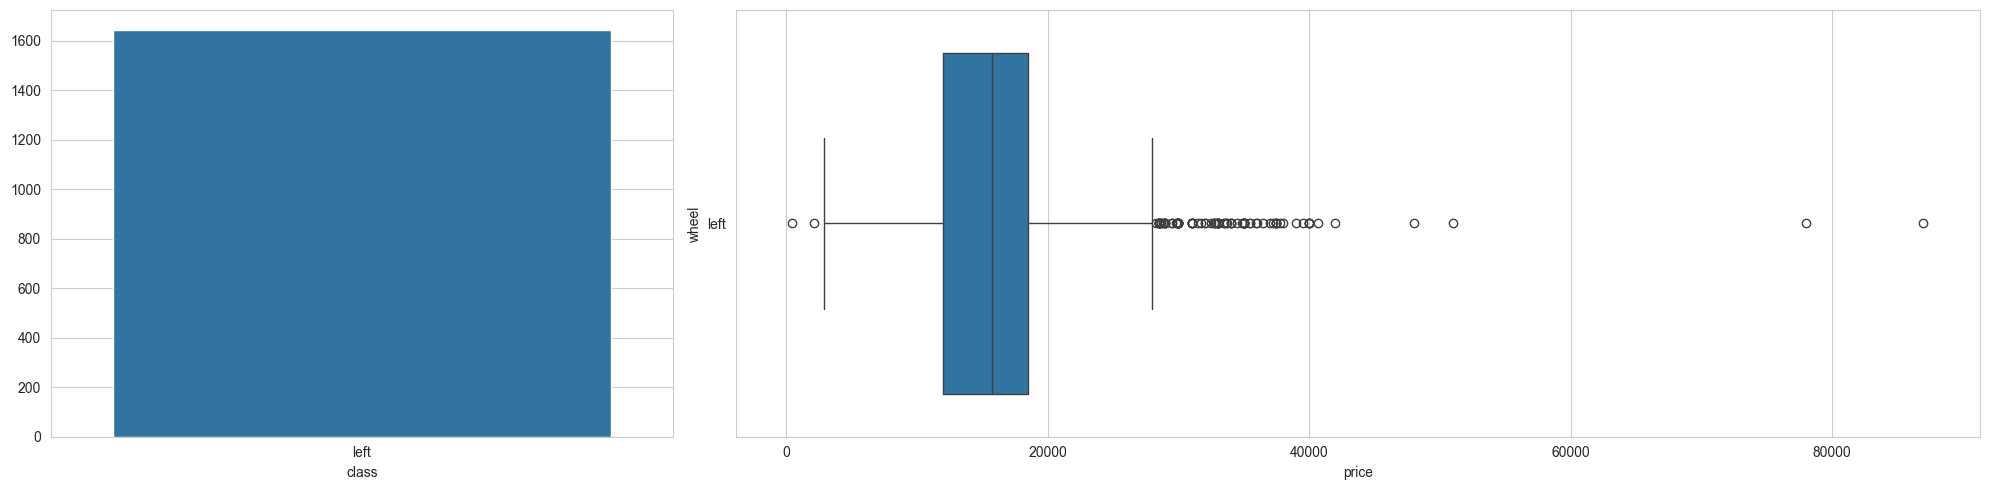

Feautre: color


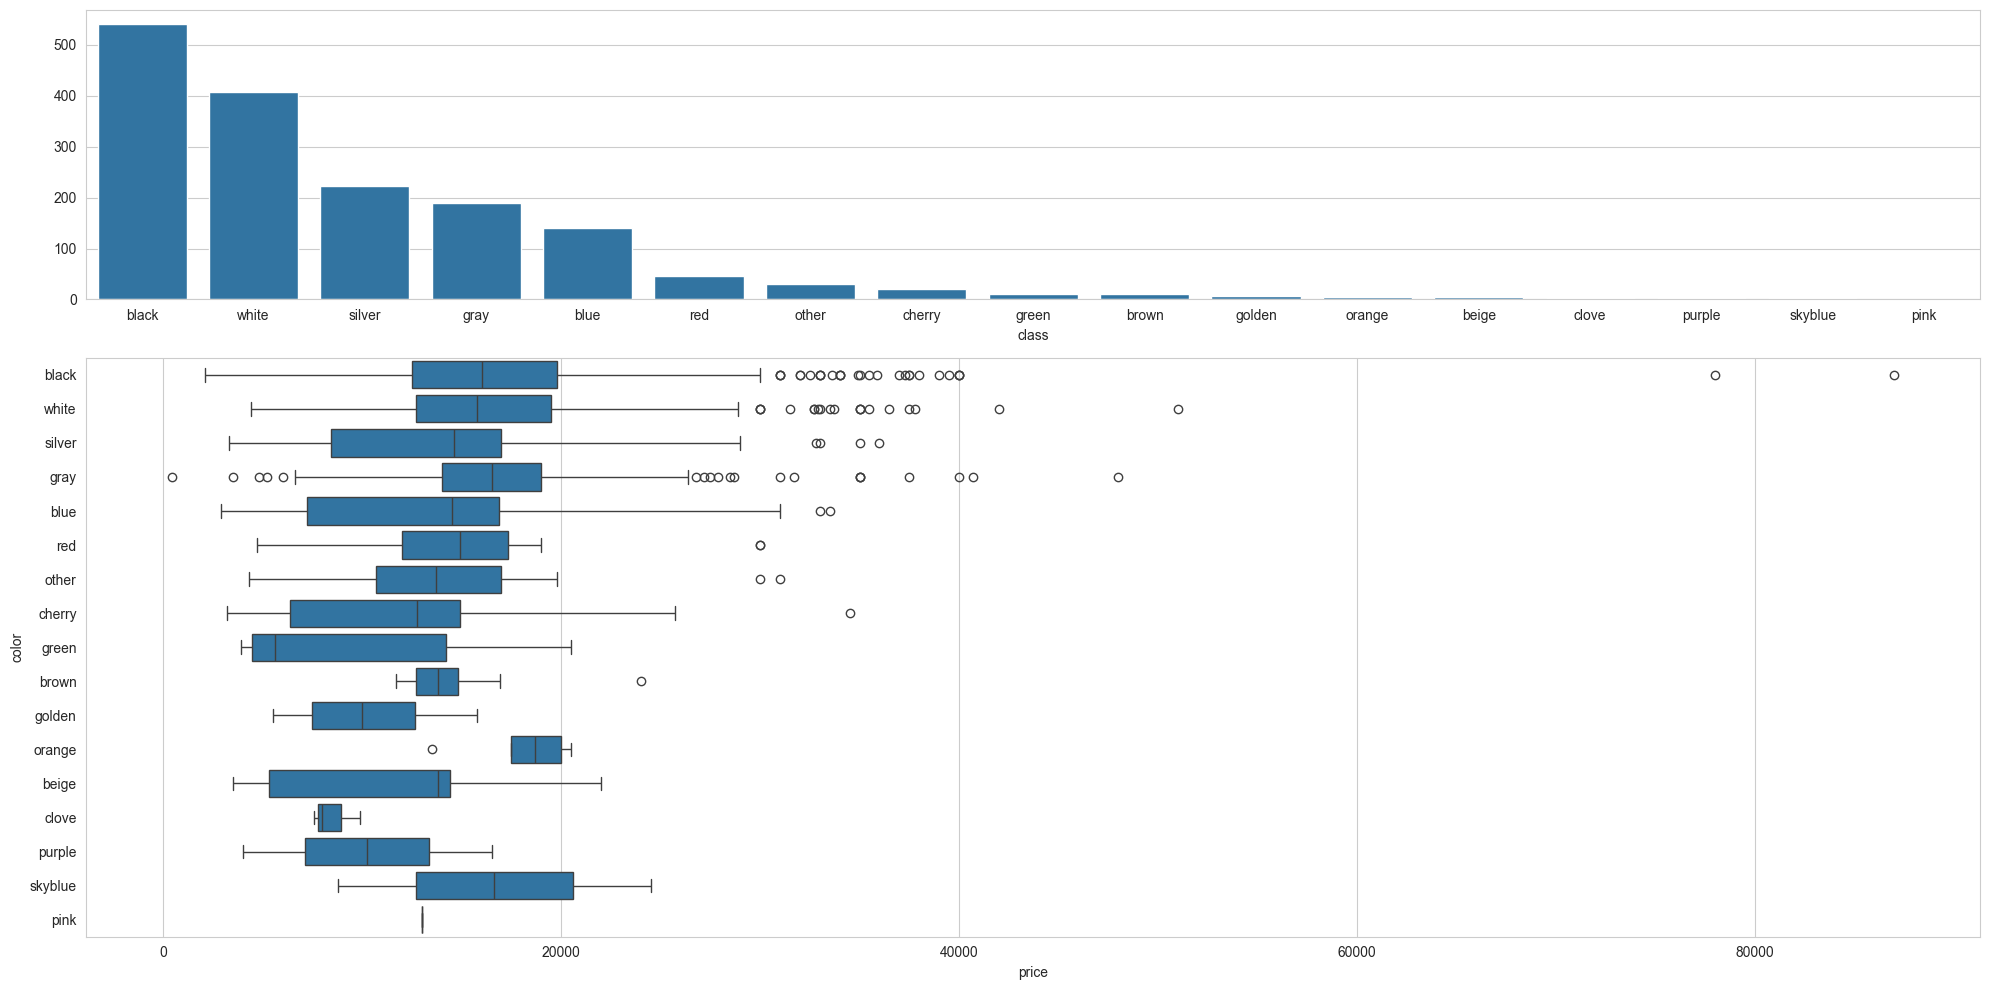

Feautre: type


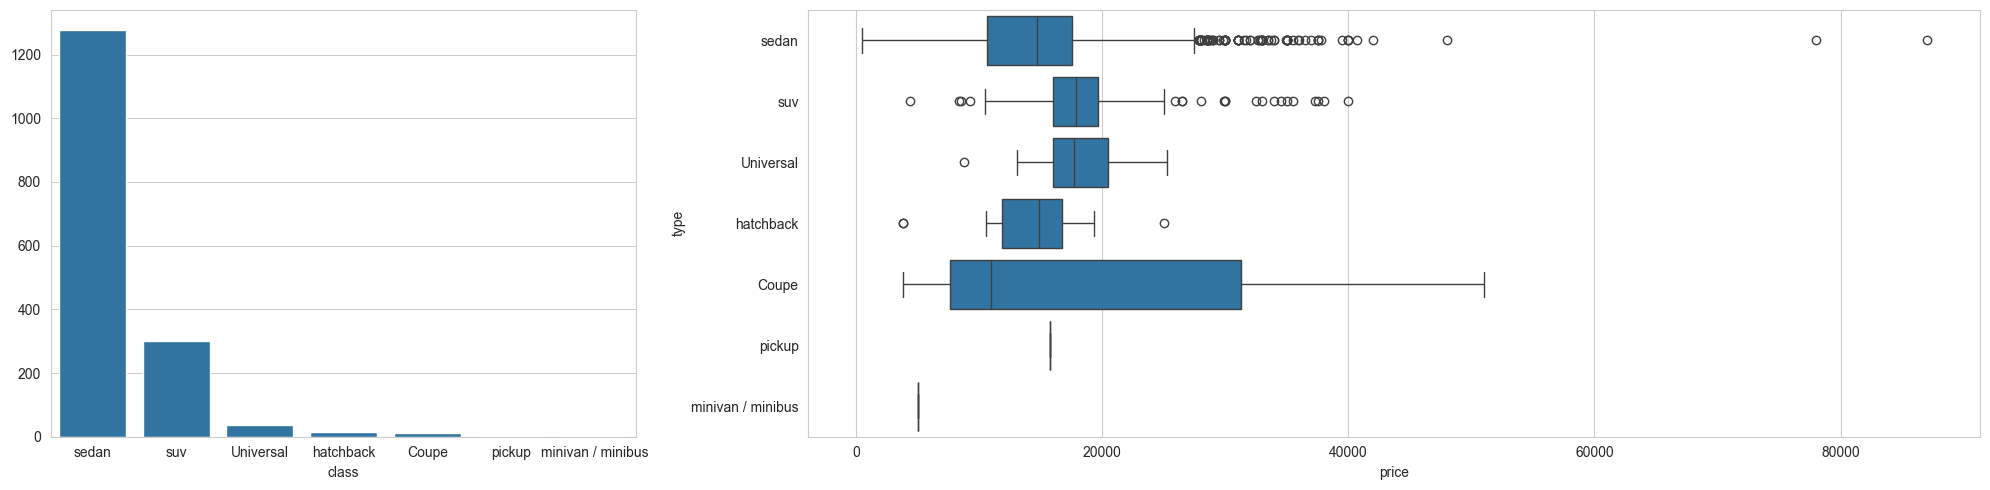

Feautre: status


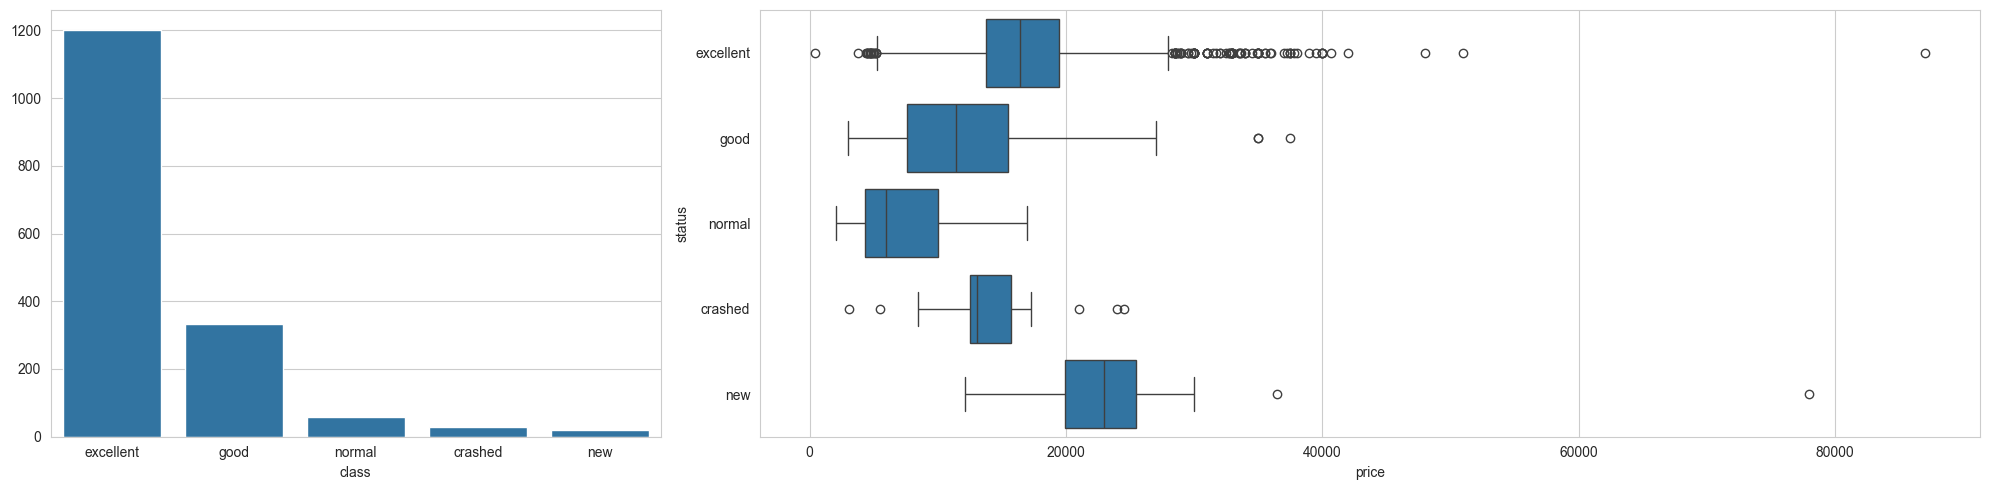

Feautre: motor_volume


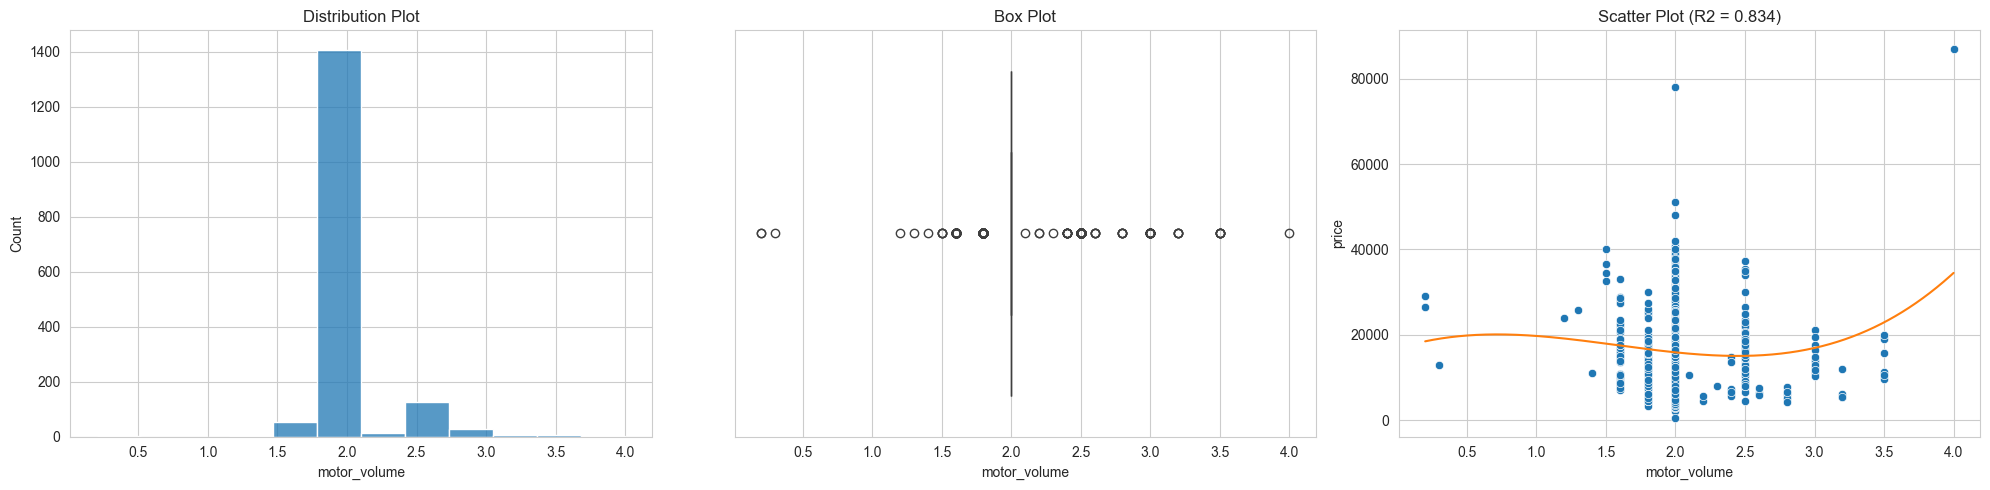

Feautre: running_km


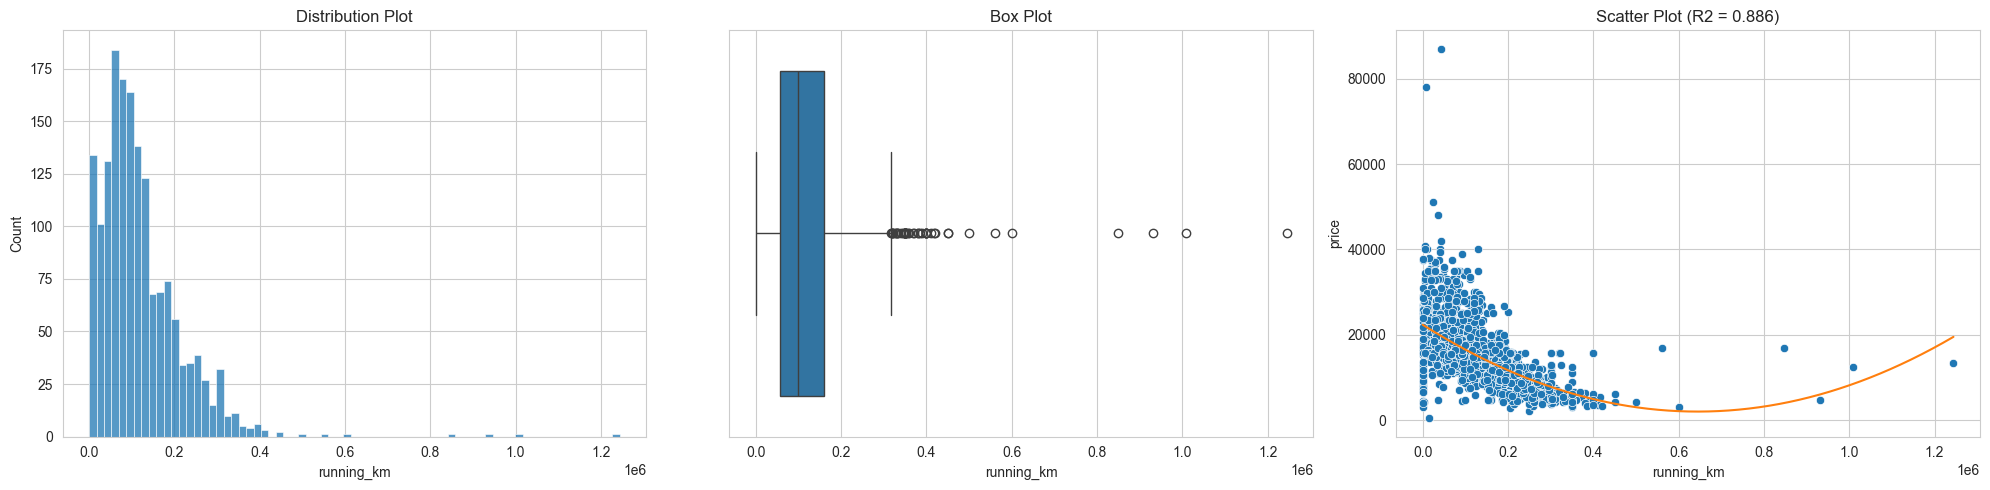

In [7]:
def plot_numerical_feature(data, target):
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    sns.histplot(data, ax=axes[0], color=color_pal[0])
    axes[0].set_title('Distribution Plot')

    sns.boxplot(data, ax=axes[1], color=color_pal[0], orient='h')
    axes[1].set_title('Box Plot')
    
    sns.scatterplot(x=data, y=target, ax=axes[2], color=color_pal[0])
    pfit, residuals, rank, singular_values, rcond = np.polyfit(x=data, y=target, deg=3, full=True)
    xfitted = np.linspace(min(data), max(data), 1000)
    fitmodel = np.poly1d(pfit)
    yfitted = fitmodel(xfitted)
    plt.plot(xfitted, yfitted, color=color_pal[1])
    r2 = float(1-residuals/(sum(np.square(target))))
    axes[2].set_title(f'Scatter Plot (R2 = {r2:.3f})')
    
    plt.tight_layout()
    plt.show()
    
def plot_categorical_feature(data, target):
    if len(np.unique(data)) > 50:
        print(f"More than 10 categorical features: {len(np.unique(data))}. Skipping.")
        return
    
    if len(np.unique(data)) > 10:
        fig, axes = plt.subplots(2, 1, figsize=(20, 10), height_ratios=(1/3, 2/3))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(20, 5), width_ratios=(1/3, 2/3))
    s = data.value_counts().rename_axis('class').rename('count') # if x- and y-labels are important
    sns.barplot(x=s.index, y=s.values, order=s.index, ax=axes[0])
#     sns.countplot(x=data, ax=axes[0])
    sns.boxplot(x=target, y=data, ax=axes[1], order=s.index, orient='h')
    plt.tight_layout()
    plt.show()
    return

def plot_feature(data, target):
    if str(data[0]).replace(".", "").isdecimal():
        plot_numerical_feature(data, target)
    else:
        plot_categorical_feature(data, target)
    return

def plot_features(df):
    for feature in df.columns.values:
        if feature == 'price':
            continue
        print(f"Feautre: {feature}")
        plot_feature(df[feature], df['price'])
    return

# plot_numerical_feature(train_df['year'], train_df['price'])
# plot_categorical_feature(train_df['model'], train_df['price'])
plot_features(train_df)

In [8]:
y = train_df['price']
features = ['model', 'year', 'motor_type', 'color', 'type', 'status', 'motor_volume', 'running_km']
X = train_df[features]

X_encoded = X.apply(lambda x: label_encoder_dict[x.name].fit_transform(x))

# Split the test data into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X_encoded, y, random_state=1)

# Decision Tree

In [9]:
# Define the model. Set random_state to 1. Fit the model using the training data.
dt_model = DecisionTreeRegressor(random_state = 1)
dt_model.fit(train_X, train_y)
# Predict values for the validation data
predictions = dt_model.predict(val_X)

# Calculate the Mean Absolute Error (MAE) comparing our predicted results to the actual values
dt_val_mae = mean_absolute_error(val_y, predictions)

print(f"Validation MAE for Decision Tree Model: {dt_val_mae:.2f}")

Validation MAE for Decision Tree Model: 3329.63


# Random Forest
Here we'll use the sklearn random forest regressor, but since it only takes numerical data first we must encode our categorical variables into numbers.



In [10]:
# Define the model. Set random_state to 1. Fit the model using the training data.
rf_model = RandomForestRegressor(random_state = 1)
rf_model.fit(train_X, train_y)
# Predict values for the validation data
predictions = rf_model.predict(val_X)

# Calculate the Mean Absolute Error (MAE) comparing our predicted results to the actual values
rf_val_mae = mean_absolute_error(val_y, predictions)

print(f"Validation MAE for Random Forest Model: {rf_val_mae:.2f}")

Validation MAE for Random Forest Model: 2529.40


This achieved a public score of 2827, a decent result for a quick analysis!

# Gradient Boosting
We expect that this will give slightly better results.

In [11]:
# Define the model. Set random_state to 1. Fit the model using the training data.
gb_model = GradientBoostingRegressor(random_state = 1)
gb_model.fit(train_X, train_y)
# Predict values for the validation data
predictions = gb_model.predict(val_X)

# Calculate the Mean Absolute Error (MAE) comparing our predicted results to the actual values
gb_val_mae = mean_absolute_error(val_y, predictions)

print(f"Validation MAE for Gradient Boosting Model: {gb_val_mae:.2f}")

Validation MAE for Gradient Boosting Model: 2288.60


This has been producing an MAE of 2288.6 here, but on submission generates a score of 2957.

# Histogram Gradient Boosting


In [12]:
# Define the model. Set random_state to 1. Fit the model using the training data.
hgb_model = HistGradientBoostingRegressor(random_state = 1)
hgb_model.fit(train_X, train_y)
# Predict values for the validation data
predictions = hgb_model.predict(val_X)

# Calculate the Mean Absolute Error (MAE) comparing our predicted results to the actual values
hgb_val_mae = mean_absolute_error(val_y, predictions)

print(f"Validation MAE for Histogram Gradient Boosting Model: {hgb_val_mae:.2f}")

Validation MAE for Histogram Gradient Boosting Model: 2396.02


This has been producing an MAE of 2396, but on submission generates a score of 3012

# Adaboost

In [13]:
# Define the model. Set random_state to 1. Fit the model using the training data.
ada_model = AdaBoostRegressor(random_state = 1)
ada_model.fit(train_X, train_y)
# Predict values for the validation data
predictions = ada_model.predict(val_X)

# Calculate the Mean Absolute Error (MAE) comparing our predicted results to the actual values
ada_val_mae = mean_absolute_error(val_y, predictions)

print(f"Validation MAE for AdaBoost Model: {ada_val_mae:.2f}")

Validation MAE for AdaBoost Model: 3643.49


# With Hyperparameter Tuning


# Compile Final Solution
The Graident Boosting Model has been giving us the best results so far. Let's try that.
Make sure to match the format of the Sample Submission. Also we need to train the model one more time using the full data set.

In [14]:
# Compile final model from full training data
dt_model.fit(X_encoded, y)

DecisionTreeRegressor(random_state=1)

In [15]:
# Generate a prediction from the final test data
final_df = test_df
add_odometer(final_df)
final_df = final_df.apply(lambda x: label_encoder_dict[x.name].fit_transform(x))
final_X = final_df[features]
final_predictions = dt_model.predict(final_X)
predictions_df = pd.DataFrame(data={'Id': [pid for pid in final_df['Id'].unique()], 'price': final_predictions})
predictions_df.to_csv("submission.csv", header=['Id', 'price'], index=False)
print(predictions_df)

      Id    price
0      0  17300.0
1      1  16300.0
2      2  19000.0
3      3  12800.0
4      4  15750.0
..   ...      ...
406  406  33000.0
407  407  15500.0
408  408  12000.0
409  409  11600.0
410  410  11500.0

[411 rows x 2 columns]
